In [1]:
import pandas as pd
from pathlib import Path

from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold

from imblearn import over_sampling as ovs
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV,RepeatedKFold
from sklearn.model_selection import train_test_split

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,quantile_transform,PowerTransformer
from scipy import stats

%matplotlib inline

In [2]:
sns.set_context(context="paper")


In [4]:

#dataframe final
df_final = pd.read_csv("../data/DF_contact400_energy_sasa.FcorrZero.csv",index_col=0)
# Quitar modelos por homologia deltraining set
#df_final_onlyHM = df_final.loc[df_final.index.str.startswith("HM")]
#df_final= df_final.loc[~df_final.index.str.startswith("HM")]

index_ddg8 = (df_final['ddG_exp']>6.3)
df_final = df_final.loc[-index_ddg8]
#testiar eliminando estructuras con ddg menor o igual a -4 kcal/mol , outliers
index_ddg_4 =  (df_final['ddG_exp'] <= -4)
df_final = df_final.loc[-index_ddg_4]


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns


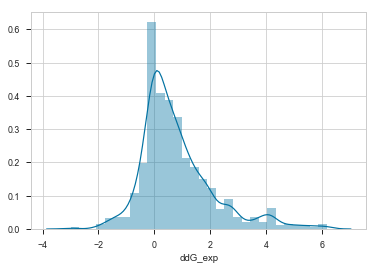

In [5]:
sns.distplot(df_final['ddG_exp'])

# models normal

In [6]:
X = df_final.drop('ddG_exp',axis=1)
y = df_final['ddG_exp']

In [7]:
mx = MinMaxScaler().fit(X)
xmx = mx.transform(X)

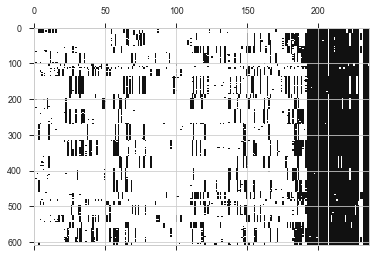

In [8]:
plt.spy(xmx,aspect='auto')


In [9]:
k2, p = stats.normaltest(y)
alpha = 1e-3
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 1.08779e-32
The null hypothesis can be rejected


Text(0.5, 1.0, 'Probplot after Yeo-Johnson transformation')

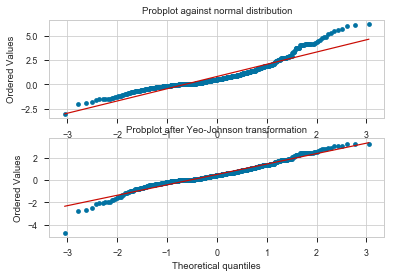

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(y, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, lmbda = stats.yeojohnson(y)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Yeo-Johnson transformation')

In [11]:
k2, p = stats.normaltest(xt)
alpha = 1e-3
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 1.82607e-08
The null hypothesis can be rejected


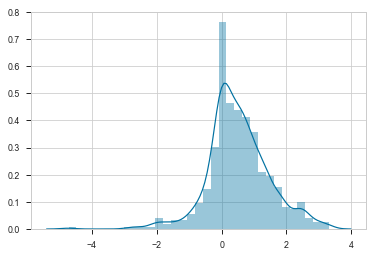

In [12]:
sns.distplot(xt)

In [13]:
# binned split
bins = np.linspace(0, len(X), 50)
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned,random_state=1)


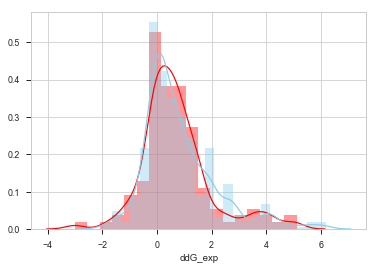

In [14]:
sns.distplot( y_test , color="red", label="ddG_exp_test")
sns.distplot( y_train , color="skyblue", label="ddG_exp_train")


# Linear, default

In [18]:
# Load a regression dataset

selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = StandardScaler()
#2)
lr_model = LinearRegression()
#3) Crear pipeline
pipeline1 = make_pipeline(scaler,selector,lr_model)

regr_trans = TransformedTargetRegressor(
    regressor=pipeline1, transformer=PowerTransformer())

cv = RepeatedKFold(n_splits=10,n_repeats=5,random_state=13)
# 5) hiperparametros a ajustar
param_grid = {"regressor__linearregression__fit_intercept":[True,False],"regressor__linearregression__normalize":[True,False],
             'regressor__variancethreshold__threshold':[0.01]}

#param_grid = {"linearregression__fit_intercept":[True,False],"linearregression__normalize":[True,False],'pca__n_components':[10,20,30,40,50,60,70,80,90,100]}
grid1 = GridSearchCV(regr_trans, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','explained_variance','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)
# fit
grid1.fit(X_train, y_train)


Fitting 50 folds for each of 4 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a22829e48>,
       error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
              transformer=PowerTransformer(copy=True, method='yeo-johnson', standardize=True)),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'regressor__linearregression__fit_intercept': [True, False], 'regressor__linearregression__normalize': [True, False], 'regressor__variancethreshold__threshold': [0.01]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True,
       scoring=['neg_mean_squared_error', 'explained_vari

In [19]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()


# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]


print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',grid1.score(X_test,y_test))
print('R2 train',grid1.score(X_train,y_train))


CV test RMSE 50.529707 +/- 118.592667
CV train RMSE 0.719646 +/- 0.148772
CV test r2 -1520.142069 +/- 7835.971786
CV train r2 0.704776 +/- 0.010891
{'regressor__linearregression__fit_intercept': False, 'regressor__linearregression__normalize': True, 'regressor__variancethreshold__threshold': 0.01}

RMSE for test dataset: 1.22
RMSE for train dataset: 0.74
pearson corr  0.491201
R2 test -1.4965828230725926
R2 train -0.5529319870184934


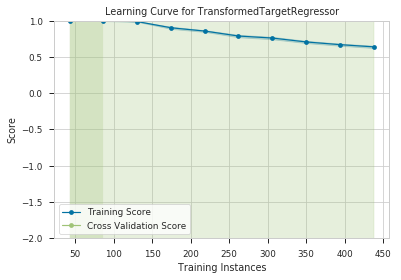

In [223]:
viz = LearningCurve(grid1.best_estimator_, n_jobs=-1,cv=cv, scoring='r2',train_sizes=np.linspace(.1, 1.0, 10))
viz.fit(X_train, y_train)
plt.ylim(-1,1)
viz.poof()

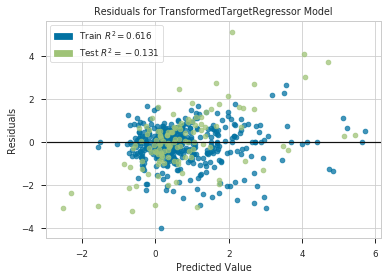

In [224]:
visualizer = ResidualsPlot(grid1.best_estimator_,hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


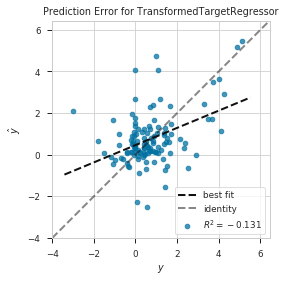

In [225]:
perror = PredictionError(grid1.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof()

# l2 regularization or Ridge, default

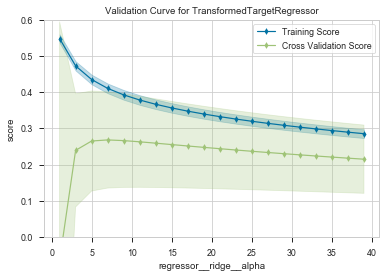

In [18]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#2)
lr_model = Ridge()

#3) Crear pipeline
pipeline2 = make_pipeline(scaler,selector,lr_model)

regr_trans = TransformedTargetRegressor(
    regressor=pipeline2, transformer=PowerTransformer())

# Extract the instances and target
viz = ValidationCurve(
    regr_trans, njobs=-1,param_name="regressor__ridge__alpha",
    param_range=np.arange(1,40,2), cv=10, scoring="r2"
)
plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [48]:
#1)
selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = StandardScaler()
#2)
lr_model = Ridge()
#3) Crear pipeline
pipeline2 = make_pipeline(scaler,selector,lr_model)

regr_trans = TransformedTargetRegressor(
    regressor=pipeline2, transformer=PowerTransformer())

cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13)
# 5) hiperparametros a ajustar
param_grid = {"regressor__ridge__alpha":[20],"regressor__ridge__normalize":[True,False],"regressor__ridge__fit_intercept":[True,False],
             'regressor__variancethreshold__threshold':[0.01,0.0]}

grid2 = GridSearchCV(regr_trans, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)
#grid2 = GridSearchCV(pipeline2, param_grid, verbose=5, n_jobs=-1,cv=10,scoring='r2',return_train_score=True)
# fit
grid2.fit(X_train, y_train)


Fitting 50 folds for each of 8 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 288 out of 400 | elapsed:    1.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.3s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a220ba128>,
       error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('ridge', Ridge(alpha=1.0, copy_X...))]),
              transformer=PowerTransformer(copy=True, method='yeo-johnson', standardize=True)),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'regressor__ridge__alpha': [20], 'regressor__ridge__normalize': [True, False], 'regressor__ridge__fit_intercept': [True, False], 'regressor__variancethreshold__threshold': [0.01, 0.0]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=5)

In [49]:
# index of best scores
rmse_bestCV_test_index = grid2.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid2.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid2.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid2.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid2.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid2.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid2.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid2.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid2.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid2.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid2.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid2.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid2.best_params_)
y_test_pred = grid2.best_estimator_.predict(X_test)
y_train_pred = grid2.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',grid2.score(X_test,y_test))
print('R2 train',grid2.score(X_train,y_train))

CV test RMSE 1.115295 +/- 0.494450
CV train RMSE 1.031864 +/- 0.212924
CV test r2 0.283674 +/- 0.071095
CV train r2 0.392812 +/- 0.015894
0.10913797212105392
 {'regressor__ridge__alpha': 20, 'regressor__ridge__fit_intercept': True, 'regressor__ridge__normalize': False, 'regressor__variancethreshold__threshold': 0.0}

RMSE for test dataset: 1.05
RMSE for train dataset: 1.03
pearson corr  0.577205
R2 test 0.33106645203441
R2 train 0.3899585187969129


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


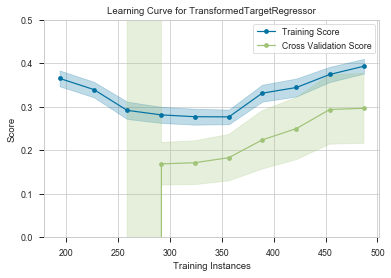

In [45]:

viz = LearningCurve(grid2.best_estimator_, n_jobs=-1,cv=cv, scoring='r2',train_sizes=np.linspace(.4, 1.0, 10))
viz.fit(X, y)
plt.ylim(0,0.5)
viz.poof()

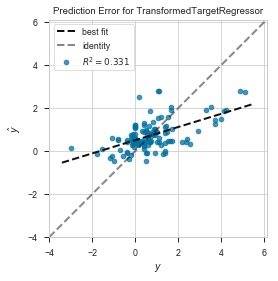

In [46]:
perror = PredictionError(grid2.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof()

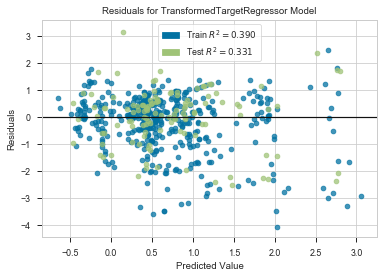

In [47]:
visualizer = ResidualsPlot(grid2.best_estimator_,hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


In [50]:
final_linear = grid2.best_estimator_.fit(X,y)
# save final model

joblib.dump(final_linear, 'Ridgemodel_contact400energy_sasa_fCorr.pkl')

['Ridgemodel_contact400energy_sasa_fCorr.pkl']

# l1 Regularization or Lasso Regression

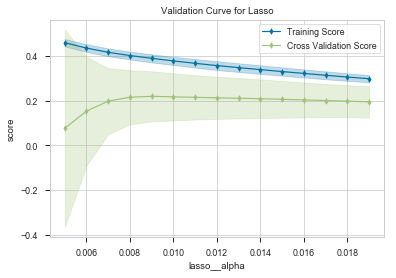

In [367]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = StandardScaler()
#2)
lr_model = Lasso(max_iter=5000,fit_intercept=True)
#3) Crear pipeline
pipeline3 = make_pipeline(scaler,selector,lr_model)

# Extract the instances and target
viz = ValidationCurve(
    pipeline3, njobs=-1,param_name="lasso__alpha",
    param_range=np.arange(0.005,0.02,0.001), cv=10, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [57]:
selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = StandardScaler()
#2)
lr_model = Lasso()
#3) Crear pipeline
pipeline3 = make_pipeline(scaler,selector,lr_model)


# fit
pipeline3.fit(X_train,y_train)

regr_trans = TransformedTargetRegressor(
    regressor=pipeline3, transformer=PowerTransformer())
# 5) hiperparametros a ajustar
cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13)

param_grid = {"regressor__lasso__alpha":[0.006],"regressor__lasso__normalize":[True,False],"regressor__lasso__fit_intercept":[True,False],
             'regressor__variancethreshold__threshold':[0.01,0.0]}

grid3 = GridSearchCV(regr_trans, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)
# fit
grid3.fit(X_train, y_train)


Fitting 50 folds for each of 8 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.4s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a21e6a160>,
       error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('lasso', Lasso(alpha=1.0, copy_X...))]),
              transformer=PowerTransformer(copy=True, method='yeo-johnson', standardize=True)),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'regressor__lasso__alpha': [0.006], 'regressor__lasso__normalize': [True, False], 'regressor__lasso__fit_intercept': [True, False], 'regressor__variancethreshold__threshold': [0.01, 0.0]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=5)

In [58]:
# index of best scores
rmse_bestCV_test_index = grid3.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid3.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid3.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid3.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid3.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid3.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid3.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid3.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid3.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid3.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid3.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid3.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid3.best_params_)
y_test_pred = grid3.best_estimator_.predict(X_test)
y_train_pred = grid3.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',grid3.score(X_test,y_test))
print('R2 train',grid3.score(X_train,y_train))

CV test RMSE 1.101241 +/- 0.487972
CV train RMSE 0.991060 +/- 0.219093
CV test r2 0.300741 +/- 0.075597
CV train r2 0.439932 +/- 0.018457
0.13919137905034107
 {'regressor__lasso__alpha': 0.006, 'regressor__lasso__fit_intercept': True, 'regressor__lasso__normalize': False, 'regressor__variancethreshold__threshold': 0.0}

RMSE for test dataset: 1.06
RMSE for train dataset: 1.01
pearson corr  0.564606
R2 test 0.31795169440138693
R2 train 0.4209675928698785


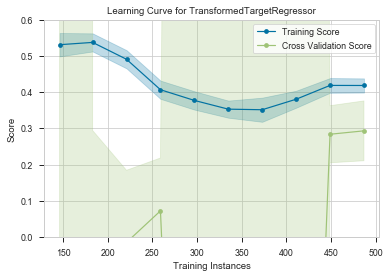

In [53]:
viz = LearningCurve(grid3.best_estimator_, n_jobs=-1,cv=cv, scoring='r2',train_sizes=np.linspace(.3, 1.0, 10))
viz.fit(X, y)
plt.ylim(-0,0.6)
viz.poof()

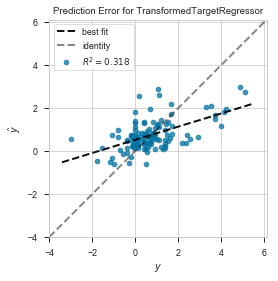

In [54]:
perror = PredictionError(grid3.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof()

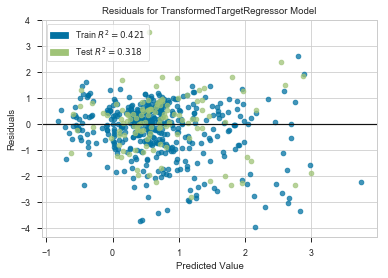

In [55]:
visualizer = ResidualsPlot(grid3.best_estimator_,hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


In [59]:
final_linear = grid3.best_estimator_.fit(X,y)
# save final model

joblib.dump(final_linear, 'Lassomodel_contact400energy_sasa_fCorr.pkl')

['Lassomodel_contact400energy_sasa_fCorr.pkl']

# ElasticNet

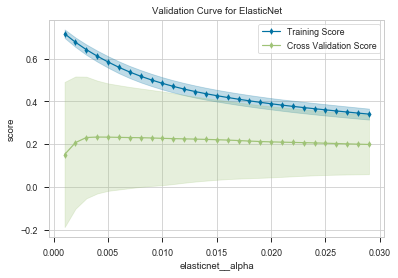

In [51]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = StandardScaler()
#2)
lr_model = ElasticNet(random_state=1212)
#3) Crear pipeline

pipeline4 = make_pipeline(scaler,selector,lr_model)

# Extract the instances and target
viz = ValidationCurve(
    pipeline4, njobs=-1,param_name="elasticnet__alpha",
    param_range=np.arange(0.001,0.03,0.001), cv=10, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [76]:
selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = StandardScaler()
lr_model = ElasticNet()
#3) Crear pipeline
pipeline4 = make_pipeline(scaler,selector,lr_model)


# fit
pipeline4.fit(X_train,y_train)

# 5) hiperparametros a ajustar
cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13)
regr_trans = TransformedTargetRegressor(
    regressor=pipeline4, transformer=PowerTransformer(standardize=False))

param_grid = {"regressor__elasticnet__alpha":[0.006],'regressor__elasticnet__l1_ratio':[0.9],"regressor__elasticnet__normalize":[True,False],
              "regressor__elasticnet__fit_intercept":[False,True],'regressor__variancethreshold__threshold':[0.01,0.0]}

grid4 = GridSearchCV(regr_trans, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)
# fit
grid4.fit(X_train, y_train)

Fitting 50 folds for each of 8 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.2s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a220dc898>,
       error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('elasticnet', ElasticNet(alpha=1...)]),
              transformer=PowerTransformer(copy=True, method='yeo-johnson', standardize=False)),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'regressor__elasticnet__alpha': [0.006], 'regressor__elasticnet__l1_ratio': [0.9], 'regressor__elasticnet__normalize': [True, False], 'regressor__elasticnet__fit_intercept': [False, True], 'regressor__variancethreshold__threshold': [0.01, 0.0]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=5)

In [77]:
# index of best scores
rmse_bestCV_test_index = grid4.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid4.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid4.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid4.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid4.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid4.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid4.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid4.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid4.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid4.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid4.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid4.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))
print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid4.best_params_)
y_test_pred = grid4.best_estimator_.predict(X_test)
y_train_pred = grid4.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',grid4.score(X_test,y_test))
print('R2 train',grid4.score(X_train,y_train))

CV test RMSE 1.102637 +/- 0.488707
CV train RMSE 0.996600 +/- 0.217303
CV test r2 0.299217 +/- 0.073751
CV train r2 0.433581 +/- 0.019705
0.13436346042091718
 {'regressor__elasticnet__alpha': 0.006, 'regressor__elasticnet__fit_intercept': False, 'regressor__elasticnet__l1_ratio': 0.9, 'regressor__elasticnet__normalize': True, 'regressor__variancethreshold__threshold': 0.0}

RMSE for test dataset: 1.06
RMSE for train dataset: 1.01
pearson corr  0.560109
R2 test 0.3128813847638694
R2 train 0.41334162477708625


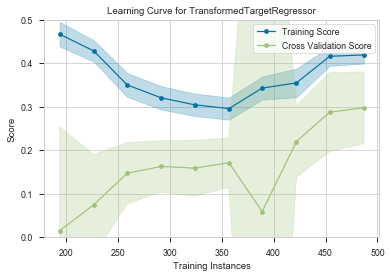

In [80]:
viz = LearningCurve(grid4.best_estimator_, n_jobs=-1,cv=cv, scoring='r2',train_sizes=np.linspace(.4, 1.0, 10))
viz.fit(X, y)
plt.ylim(0,0.5)
viz.poof()

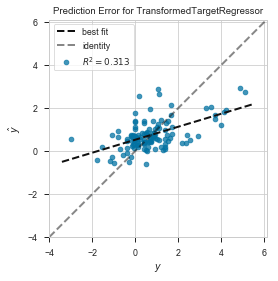

In [81]:
perror = PredictionError(grid4.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof()

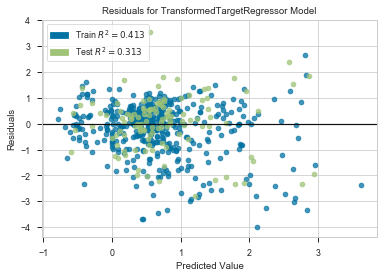

In [82]:
visualizer = ResidualsPlot(grid4.best_estimator_,hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


In [83]:
final_linear = grid4.best_estimator_.fit(X,y)
# save final model

joblib.dump(final_linear, 'Elasticmodel_contact400energy_sasa_fCorr.pkl')

['Elasticmodel_contact400energy_sasa_fCorr.pkl']

In [313]:
for s in grid4.scorer_:
    # index best scorer
    scorer_bestCV_test_index = grid4.cv_results_['mean_test_%s' %(s)].argmax()
    scorer_bestCV_train_index = grid4.cv_results_['mean_train_%s' %(s)].argmax()
    
    # scores test
    scorer_bestCV_test_score = grid4.cv_results_['mean_test_%s' %(s)][scorer_bestCV_test_index]
    scorer_bestCV_test_std = grid4.cv_results_['std_test_%s' %(s)][scorer_bestCV_test_index]
    # scores train
    scorer_bestCV_train_score = grid4.cv_results_['mean_train_%s' %(s)][scorer_bestCV_test_index]
    scorer_bestCV_train_std = grid4.cv_results_['std_train_%s' %(s)][scorer_bestCV_test_index]
    
    

# Apply SMOTE, only on train data, and test only one
https://stackoverflow.com/questions/48370150/how-to-implement-smote-in-cross-validation-and-gridsearchcv

In [154]:
# forma 1
df_final['class'] = np.where((df_final['ddG_exp'] < -0.4) | (df_final['ddG_exp'] > 2),0,1)
# forma 2 
#df_final['class'] = np.where((df_final['ddG_exp'] < 0),1,0)


In [155]:
print("Before OverSampling, counts of label '1': {}".format(sum(df_final['class'] == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(df_final['class'] == 0)))

Before OverSampling, counts of label '1': 467
Before OverSampling, counts of label '0': 148


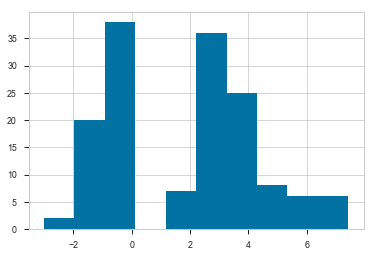

In [156]:
df_final.loc[df_final['class'] == 0]['ddG_exp'].hist()

In [157]:
X = df_final.drop('class',axis=1)
y = df_final['class']

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y,train_size=0.75,random_state=1212)


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [186]:
#smote = ovs.SMOTE(random_state=1212,m_neighbors=25)
#smote = ovs.BorderlineSMOTE(random_state=1212,m_neighbors=10,kind='borderline-2')
adasyn = ovs.ADASYN(random_state=10,n_neighbors=10)
X_train_re , y_train_re = adasyn.fit_sample(X_train,y_train)
#X_train_re , y_train_re = smote.fit_sample(X_train,y_train)

In [187]:
# back to originalk shape and target
X_train_normal = X_train_re[:,:-1]
y_train_normal = X_train_re[:,-1]

X_test_normal = X_test.iloc[:,:-1]
y_test_normal = X_test.iloc[:,-1]


In [194]:
model = grid2.best_estimator_.fit(X_train_normal,y_train_normal)
#print('CV test RMSE',np.sqrt(-grid.best_score_))
#print('CV train RMSE',np.sqrt(-grid.cv_results_['mean_train_score'].max()))

y_test_pred = model.predict(X_test_normal.values)
y_train_pred = model.predict(X_train_normal)

print('Training score (r2): {}'.format(r2_score(y_train_normal, y_train_pred)))
print('Test score (r2): {}'.format(r2_score(y_test_normal.values, y_test_pred)))

print("\nRoot mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test_normal.values, y_test_pred)), 2)))
print("Root mean square error for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train_normal, y_train_pred)), 2)))
print("pearson corr: ",np.corrcoef(y_test_pred,y_test_normal.values)[0][1])

Training score (r2): 0.5989565134299454
Test score (r2): 0.4328913794297463

Root mean square error for test dataset: 1.15
Root mean square error for train dataset: 1.13
pearson corr:  0.6711313737113705


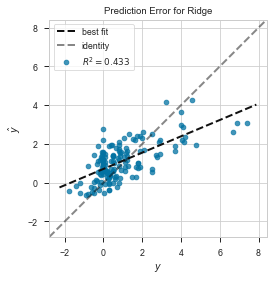

In [195]:
perror = PredictionError(model)

perror.fit(X_train_normal, y_train_normal)  # Fit the training data to the visualizer
perror.score(X_test_normal.values, y_test_normal.values)  # Evaluate the model on the test data
g = perror.poof()

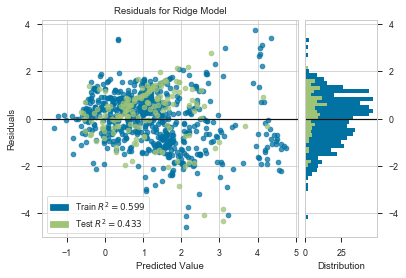

In [196]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_normal, y_train_normal)  # Fit the training data to the model
visualizer.score(X_test_normal.values, y_test_normal.values)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


# SMOTE , ADASYN , Kfold manually

In [49]:
from sklearn.compose import TransformedTargetRegressor
from imblearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold


In [198]:
df_final = df_final.astype(float,copy=True)

In [200]:
# forma 1
df_final['class'] = np.where((df_final['ddG_exp'] < -0.4) | (df_final['ddG_exp'] > 2),0,1)
# forma 2 
#df_final['class'] = np.where((df_final['ddG(kcal/mol)'] < 0),1,0)

print("Before OverSampling, counts of label '1': {}".format(sum(df_final['class'] == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(df_final['class'] == 0)))

Before OverSampling, counts of label '1': 467
Before OverSampling, counts of label '0': 148


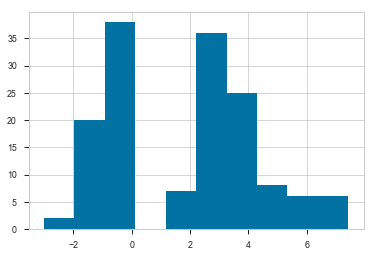

In [201]:
df_final.loc[df_final['class'] == 0]['ddG_exp'].hist()

In [202]:
X = df_final.drop('class',axis=1)
y = df_final['class']

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y,train_size=0.75,random_state=12)


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [250]:
cv_splits = 10

cv_val_mse = np.zeros(cv_splits)
cv_val_r2 = np.zeros(cv_splits)
cv_train_mse = np.zeros(cv_splits)
cv_train_r2 = np.zeros(cv_splits)

kf = KFold(n_splits=cv_splits,random_state=12)
#kf = StratifiedKFold(n_splits=cv_splits,random_state=12)
for i,(train_index, validation_index) in enumerate(kf.split(X_train,y_train)):
    
    X_train_cv, X_validation_cv = X_train.values[train_index], X_train.values[validation_index]
    y_train_cv, y_validation_cv = y_train.values[train_index], y_train.values[validation_index]
    
    # Oversampling
    #smote = ovs.SMOTE(random_state=12,m_neighbors=10)
    smote = ovs.BorderlineSMOTE(random_state=12,m_neighbors=30,kind='borderline-2')
    #adasyn = ovs.ADASYN(random_state=12,n_neighbors=10)
    #X_train_ovs , y_train_ovs = adasyn.fit_sample(X_train_cv,y_train_cv)
    X_train_ovs , y_train_ovs = smote.fit_sample(X_train_cv,y_train_cv)
    
    # Back to normal dataset
    X_train_normal = X_train_ovs[:,:-1]
    y_train_normal = X_train_ovs[:,-1]
    
    X_validation_normal = X_validation_cv[:,:-1]
    y_validation_normal = X_validation_cv[:,-1]
    
    # Standarization
    scaler = MinMaxScaler().fit(X_train_normal)
    scaler = RobustScaler().fit(X_train_normal)
    X_train_normal_std = scaler.transform(X_train_normal)
    X_validation_normal_std = scaler.transform(X_validation_normal)
    
    #Select features
    selector = VarianceThreshold().fit(X_train_normal_std)
    X_train_normal_selected = selector.transform(X_train_normal_std)
    X_validation_normal_selected = selector.transform(X_validation_normal_std)
    
    # Model
    model = Lasso(alpha=0.01,fit_intercept=False,normalize=True)
    model.fit(X_train_normal_selected,y_train_normal)
    # Test
    y_val_pred = model.predict(X_validation_normal_selected)
    y_train_pred = model.predict(X_train_normal_selected)
    
    # Scoring
    
    val_mse = mean_squared_error(y_validation_normal,y_val_pred)
    val_r2 = r2_score(y_validation_normal,y_val_pred)
    cv_val_mse[i] = val_mse
    cv_val_r2[i] = val_r2
    
    train_mse = mean_squared_error(y_train_normal,y_train_pred)
    train_r2 = r2_score(y_train_normal,y_train_pred)
    cv_train_mse[i] = train_mse
    cv_train_r2[i] = train_r2
    
print("Test scores")
print("RMSE",np.sqrt(cv_val_mse.mean()))
print("r2",cv_val_r2.mean())

print("Train scores")
print("RMSE",np.sqrt(cv_train_mse.mean()))
print("r2",cv_train_r2.mean())


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: 

Test scores
RMSE 1.472043804627576
r2 -0.04594656890735005
Train scores
RMSE 0.8037471499935007
r2 0.8214699697129749


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [232]:
print(X_train_normal_selected)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [220]:
np.sqrt(cv_test_mse)

array([1.0209668 , 1.33408245, 1.48869659, 0.85747869, 1.49938676,
       0.87571434, 0.86311325, 1.45220773, 1.28949294, 2.05810153])